# HW2 Data Pipeline

### In this notebook I...
- Build a simple, modular, extensible, machine learning pipeline in Python
- Read data (from csv)
- Explore data
- Pre-process data
- Create features
- Use 1 classifier (Logistic Regression)
- Validate (Accuracy)

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# custom functions
from helpers.processing import mean_inputation, categorical_dummies

In [2]:
%matplotlib inline
sns.set(style="darkgrid")

In [3]:
# Reading
files = ["data/credit-data.csv"]

frames = [ pd.read_csv(file) for file in files ]
for frame in frames:
    frame.columns = map(str.lower, frame.columns)
df = pd.concat(frames)

## Exploratory

In [4]:
df.isnull().sum()

personid                                    0
seriousdlqin2yrs                            0
revolvingutilizationofunsecuredlines        0
age                                         0
zipcode                                     0
numberoftime30-59dayspastduenotworse        0
debtratio                                   0
monthlyincome                           29731
numberofopencreditlinesandloans             0
numberoftimes90dayslate                     0
numberrealestateloansorlines                0
numberoftime60-89dayspastduenotworse        0
numberofdependents                       3924
dtype: int64

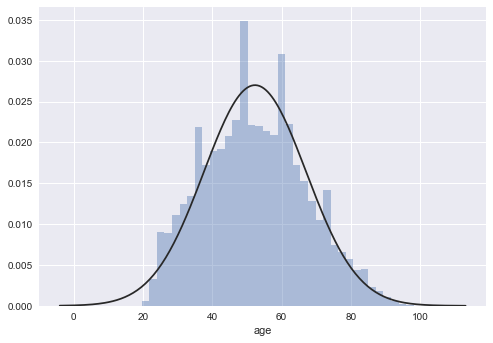

In [5]:
g = sns.distplot(df['age'], fit=stats.norm, kde=False)

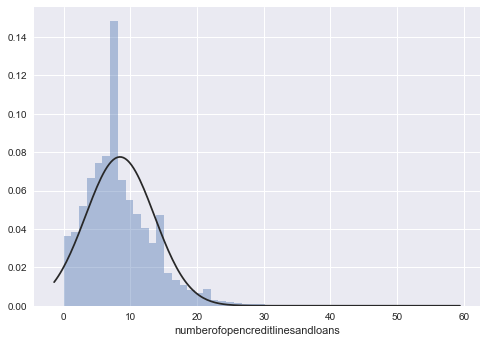

In [6]:
g = sns.distplot(df['numberofopencreditlinesandloans'], fit=stats.norm, kde=False)

### High Debt Ratios

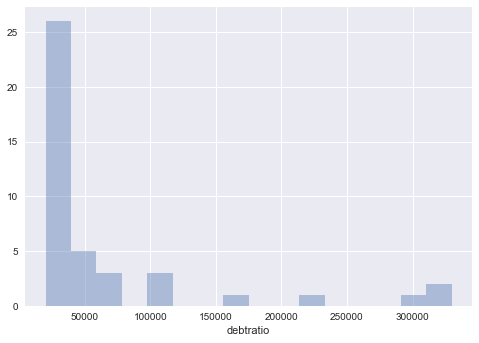

In [7]:
high_debt = df[df['debtratio'] > 20000]
g = sns.distplot(high_debt['debtratio'], kde=False)

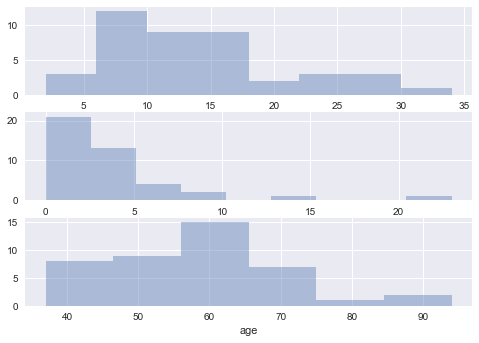

In [8]:
fig, axs = plt.subplots(nrows=3)
g = sns.distplot(high_debt['numberofopencreditlinesandloans'], kde=False, ax=axs[0])
g = sns.distplot(high_debt['numberrealestateloansorlines'], kde=False, ax=axs[1])
g = sns.distplot(high_debt['age'], kde=False, ax=axs[2])

In [24]:
hd_real_estate = high_debt['numberrealestateloansorlines'].mean()
not_high_debt = df[df['debtratio'] <= 20000]
print("Mean number of real estate loans:", not_high_debt['numberrealestateloansorlines'].mean())
print("Mean number of real estate loans for high debt ratios:", hd_real_estate)

Mean number of real estate loans: 1.0175249069739527
Mean number of real estate loans for high debt ratios: 3.5714285714285716


## Cleaning, wrangling  and feature engineering

In [9]:
df.columns

Index(['personid', 'seriousdlqin2yrs', 'revolvingutilizationofunsecuredlines',
       'age', 'zipcode', 'numberoftime30-59dayspastduenotworse', 'debtratio',
       'monthlyincome', 'numberofopencreditlinesandloans',
       'numberoftimes90dayslate', 'numberrealestateloansorlines',
       'numberoftime60-89dayspastduenotworse', 'numberofdependents'],
      dtype='object')

In [10]:
# binning
df['income_bins'] = pd.cut(df.monthlyincome, bins=15)
agebins = [0] + list(range(20, 100, 10)) + [120]
df['age_bins'] = pd.cut(df['age'], bins=agebins)

#discretization
df = categorical_dummies(df, ['numberofdependents','income_bins', 'age_bins'])

## train-test split

In [11]:
X = df.drop(['seriousdlqin2yrs','age_bins', 'income_bins'], axis=1)
y = df['seriousdlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=8)

In [12]:
# inputing
X_train = mean_inputation(X_train)
X_test = mean_inputation(X_test)

# scaling income and debt ratios
pd.options.mode.chained_assignment = None
robust_scaler = RobustScaler()
X_train['monthlyincome_scaled'] =  robust_scaler.fit_transform(X_train['monthlyincome'].values.reshape(-1,1))
X_test['monthlyincome_scaled'] =  robust_scaler.transform(X_test['monthlyincome'].values.reshape(-1,1))
X_train['debtratio_scaled'] =  robust_scaler.fit_transform(X_train['debtratio'].values.reshape(-1,1))
X_test['debtratio_scaled'] =  robust_scaler.transform(X_test['debtratio'].values.reshape(-1,1))

/Users/markvandergon/ml-for-pubpol/helpers/processing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[column] = data.fillna(inputed_value)


## Feature importance

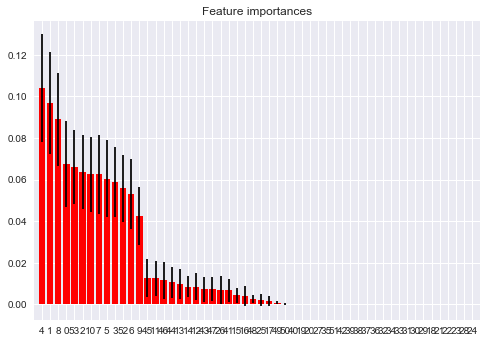

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=100)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center", )
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [14]:
print("Top Five features:",'\n', X_train[indices[:5]].columns.values)

Top Five features: 
 ['numberoftime30-59dayspastduenotworse'
 'revolvingutilizationofunsecuredlines' 'numberoftimes90dayslate'
 'personid' 'debtratio_scaled']


## Modeling

In [15]:
lr = LogisticRegression(C=1., solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

## Evaluation

In [16]:
accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)

0.93331986531986533

[[138452    121]
 [  9781    146]]


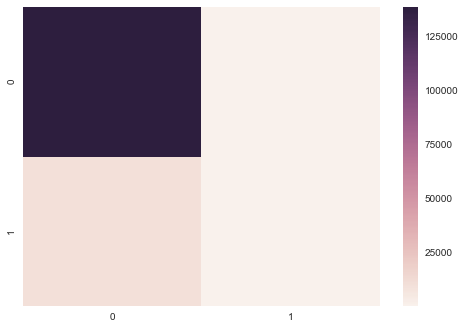

In [17]:
cfn = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(cfn)
g = sns.heatmap(cfn)

In [18]:
# examine a case where we always predict 0, or not a serious deliquency
y_base = np.zeros(y_test.shape)
accuracy_score(y_base, y_pred, normalize=True, sample_weight=None)

0.9982020202020202

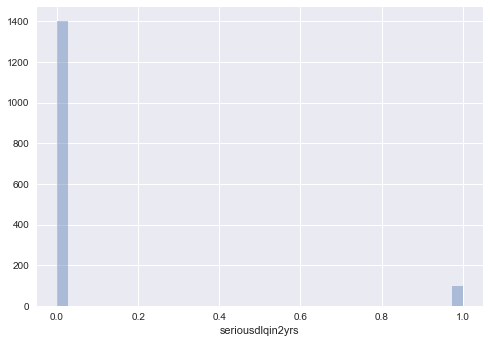

In [19]:
g = sns.distplot(y_train, kde=False)

In [20]:
# distribution of deliquency in the data
decision = y_train.value_counts()
decision[0]/decision.sum()

0.93400000000000005

#### It appears that this model isn't better on the entire dataset than just predicting no deliquency.
This model performs with an accuracy equivalent to the frequency of the label in the training data.